In [1]:
import numpy as np
import scipy.integrate
import scipy.linalg
from matplotlib import pyplot as plt
import pysindy as ps

# 1D overdamped harmonic oscillators chain

In [2]:
def U_prime(x):
    k = 1.0
    return -k*x

In [3]:
def g(t,x):
    res = []
    N = len(x) # number of oscillators
    res.append(0.0)
    for i in range(1,N-1):
        res.append(U_prime(x[i]-x[i-1]) + U_prime(x[i] - x[i+1]))
    # for i = (N-1) 
    # res.append(-k * (2*x[N-1] - x[N-2] - x[0]))
    res.append(0.0)
    return res

In [4]:
M = 4 # number of oscillators (must be even)

np.random.seed(10**5)
init_x = np.sort(np.random.uniform(-1.0, 1.0, M))

# solve the system
sol = scipy.integrate.solve_ivp(fun=g, t_span=[0,20], y0=init_x,
                                dense_output=True)

In [5]:
def true_sol(T, k=1.0, y0=init_x):
    A = np.identity(M)
    A[0,0] = 0
    for i in range(1,M-1):
        A[i,i+1] = A[i,i+1]-0.5
        A[i,i-1] = A[i,i-1]-0.5
    A[M-1, :] = 0
    return np.array([scipy.linalg.expm(-2*k*t*A)@y0 for t in T])

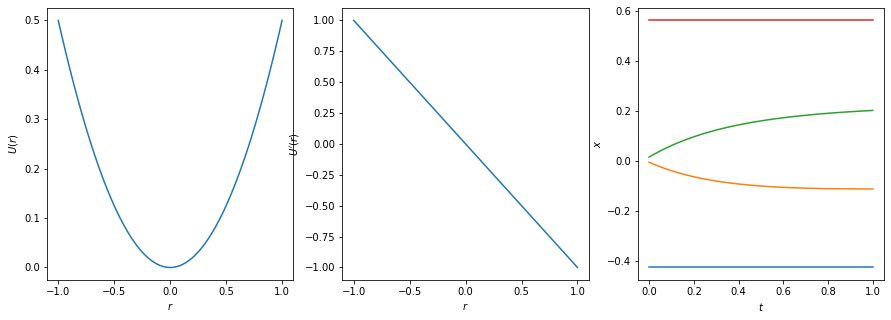

In [6]:
t = np.linspace(0,1,100)
z = sol.sol(t)# + np.random.rand(*(sol.sol(t).shape))*0.05 # add gaussian noise
x = np.linspace(-1, 1, 100)

true_y = true_sol(t)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(x, 0.5*x**2)
# plt.ylim(-6,6)
plt.xlabel('$r$')
plt.ylabel('$U(r)$')
plt.subplot(132)
plt.plot(x, U_prime(x))
plt.xlabel('$r$')
plt.ylabel('$U^\prime(r)$')
plt.subplot(133)
plt.plot(t, z.T)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

## Custom solution

In [7]:
def make_library_functions():
    return [
        lambda x : x,
        lambda x : x**2,
        lambda x : x**3,
        lambda x : x**4
    ]

def make_theta_lattice_system(x, library_functions):
    """
    Inputs:
    x: the (m,n) matrix with trajectories (m=num_samples, n=num_features)
    library_functions: A list with K functions f_p(x)
    
    Returns:
    theta, which is (m,n, K)
    """
    m = x.shape[0]
    n = x.shape[1]
    K = len(library_functions)
    theta = np.empty([m, n, K]) 
    for t in range(m):
        for i in range(n):
            for p in range(K):
                j = (i-1) 
                theta[t, i, p] = library_functions[p](x[t,i] - x[t,j])
                j = (i+1) % n
                theta[t, i, p] += library_functions[p](x[t,i] - x[t,j])
    theta[:,0,:] = 0.0
    theta[:,-1,:] = 0.0
    return theta

In [8]:
my_funs = make_library_functions()
my_funs[0](3) == 3

True

In [9]:
my_theta = make_theta_lattice_system(z.T, my_funs)
x_dot = ps.FiniteDifference(axis=-1)._differentiate(z, t=t)

In [10]:
from sklearn import linear_model
# clf = linear_model.Lasso(alpha=0.1)
clf = linear_model.LinearRegression()
clf.fit(my_theta.reshape([-1,len(my_funs)]), x_dot.T.flatten())

print(clf.coef_)

print(clf.intercept_)


[-1.00045886e+00 -6.16614022e-05  8.91450390e-04  4.31616252e-04]
-2.6093480349695386e-07


In [11]:
def pred_U_prime(x):
    coeff = clf.coef_
    return sum([c*my_fun(x) for (c,my_fun) in zip(coeff, my_funs)])

def pred_g(t,x):
    res = []
    N = len(x) # number of oscillators
    res.append(0.0)
    for i in range(1,N-1):
        res.append(pred_U_prime(x[i]-x[i-1]) + pred_U_prime(x[i] - x[i+1]))
    res.append(0.0)
    return res

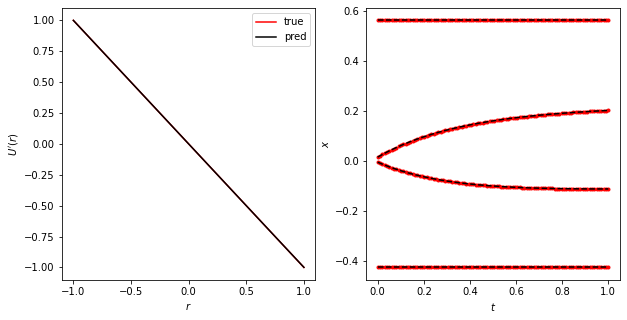

In [12]:
pred_sol = scipy.integrate.solve_ivp(fun=pred_g, t_span=[0,20], y0=init_x,
                                dense_output=True)
pred_z = pred_sol.sol(t)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, U_prime(x), 'r', label='true')
plt.plot(x, pred_U_prime(x), 'k', label='pred')
plt.xlabel('$r$')
plt.ylabel('$U^\prime(r)$')
plt.legend()
plt.subplot(122)
plt.plot(t, z.T, 'r.', label='data')
plt.plot(t, pred_z.T, 'k--', label='prediction')
plt.xlabel('$t$')
plt.ylabel('$x$')
# plt.legend()
plt.show()

# 1D double-well potential

In [13]:
def U_prime(x):
    return 0.8*x**3 - 2*x

In [14]:
def g(t,x):
    res = []
    N = len(x) # number of oscillators
    res.append(0.0)
    for i in range(1,N-1):
        res.append(U_prime(x[i]-x[i-1]) + U_prime(x[i] - x[i+1]))
    res.append(0.0)
    return res

In [164]:
M = 20 # number of oscillators (must be even)

np.random.seed(10**5)
init_x = np.sort(np.random.uniform(-5.0, 5.0, M))

# solve the system
sol = scipy.integrate.solve_ivp(fun=g, t_span=[0,20], y0=init_x,
                                dense_output=True)

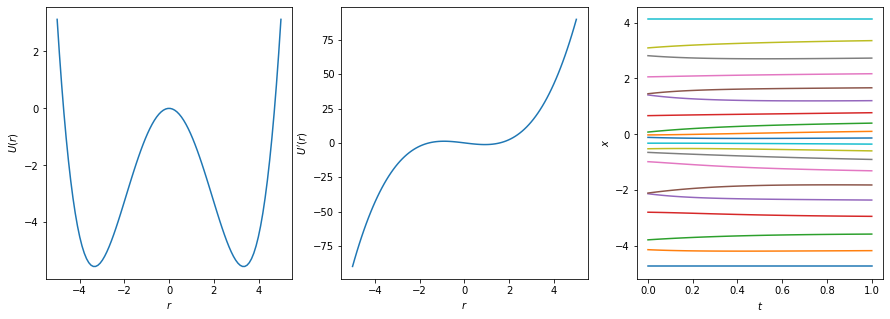

In [165]:
t = np.linspace(0,1,100)
z = sol.sol(t)# + np.random.rand(*(sol.sol(t).shape))*0.05 # add gaussian noise
x = np.linspace(-5, 5, 100)


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(x, 0.045*x**4 - x**2)
# plt.ylim(-6,6)
plt.xlabel('$r$')
plt.ylabel('$U(r)$')
plt.subplot(132)
plt.plot(x, U_prime(x))
plt.xlabel('$r$')
plt.ylabel('$U^\prime(r)$')
plt.subplot(133)
plt.plot(t, z.T)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.show()

In [166]:
def make_library_functions():
    return [
        lambda x : x,
        lambda x : x**2,
        lambda x : x**3,
        lambda x : x**4,
        lambda x : x**5,
        lambda x : x**6
    ]

def library_function_names():
    return [
        lambda x : 'r',
        lambda x : 'r^2',
        lambda x : 'r^3',
        lambda x : 'r^4',
        lambda x : 'r^5',
        lambda x : 'r^6'
    ]

def make_theta_lattice_system(x, library_functions):
    """
    Inputs:
    x: the (m,n) matrix with trajectories (m=num_samples, n=num_features)
    library_functions: A list with K functions f_p(x)
    
    Returns:
    theta, which is (m,n, K)
    """
    m = x.shape[0]
    n = x.shape[1]
    K = len(library_functions)
    theta = np.empty([m, n, K]) 
    for t in range(m):
        for i in range(n):
            for p in range(K):
                j = (i-1) 
                theta[t, i, p] = library_functions[p](x[t,i] - x[t,j])
                j = (i+1) % n
                theta[t, i, p] += library_functions[p](x[t,i] - x[t,j])
    theta[:,0,:] = 0.0
    theta[:,-1,:] = 0.0
    return theta

In [167]:
my_funs = make_library_functions()
my_fun_names = library_function_names()
my_funs[0](3) == 3

True

In [168]:
my_theta = make_theta_lattice_system(z.T, my_funs)
x_dot = ps.FiniteDifference(axis=-1)._differentiate(z, t=t)

In [169]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.00005)
# clf = linear_model.LinearRegression()
clf.fit(my_theta.reshape([-1,len(my_funs)]), x_dot.T.flatten())

print(clf.coef_)

print(clf.intercept_)


[-1.96276815e+00 -1.00769531e-04  7.30102870e-01 -0.00000000e+00
  4.20070131e-02  0.00000000e+00]
-0.00010961665827347207


In [170]:
def pred_U_prime(x):
    coeff = clf.coef_
    return sum([c*my_fun(x) for (c,my_fun) in zip(coeff, my_funs)])

def print_pred_U_prime():
    coeff = clf.coef_
    [print(str(np.round(c,2))+fun_name(x)+' + ') for (c,fun_name) in zip(coeff, my_fun_names)]
    return None

def pred_g(t,x):
    res = []
    N = len(x) # number of oscillators
    res.append(0.0)
    for i in range(1,N-1):
        res.append(pred_U_prime(x[i]-x[i-1]) + pred_U_prime(x[i] - x[i+1]))
    res.append(0.0)
    return res

In [171]:
print_pred_U_prime()

-1.96r + 
-0.0r^2 + 
0.73r^3 + 
-0.0r^4 + 
0.04r^5 + 
0.0r^6 + 


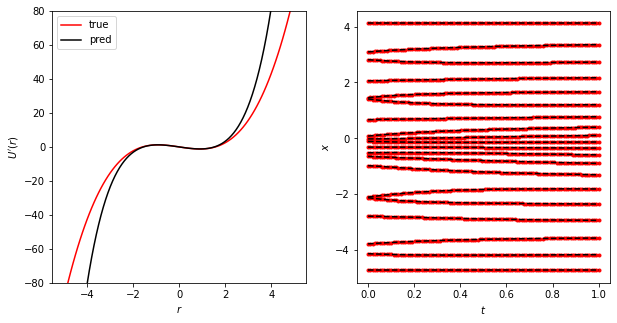

In [172]:
pred_sol = scipy.integrate.solve_ivp(fun=pred_g, t_span=[0,20], y0=init_x,
                                dense_output=True)
pred_z = pred_sol.sol(t)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, U_prime(x), 'r', label='true')
plt.plot(x, pred_U_prime(x), 'k', label='pred')
plt.ylim(-80,80)
plt.xlabel('$r$')
plt.ylabel('$U^\prime(r)$')
plt.legend()
plt.subplot(122)
plt.plot(t, z.T, 'r.', label='data')
plt.plot(t, pred_z.T, 'k--', label='prediction')
plt.xlabel('$t$')
plt.ylabel('$x$')
# plt.legend()
plt.show()